In [1]:
import os
import zipfile
import io
import sys
import pathlib
import datetime

import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cmcrameri
import scipy
import scipy.optimize

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# install from openearth/dfm_tools
from dfm_tools.get_nc_helpers import get_hisstationlist

#  install from this repository in slr folder with pip install -e .
from slr import psmsl, models

In [2]:
# places where data might be
data_dir = pathlib.Path("~/data/gtsm/sealevel_data").expanduser()
# for windows people
if not data_dir.exists():
    data_dir = pathlib.Path(r"c:\DATA\sealevel_data")
data_dir

PosixPath('/Users/baart_f/data/gtsm/sealevel_data')

In [3]:
# Get PSMS data from the internet
resp = requests.get(
    "http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip"
)

stream = io.BytesIO(resp.content)
zf = zipfile.ZipFile(stream)

stations = pd.read_csv(
    io.BytesIO(zf.read("rlr_annual/filelist.txt")),
    sep=";",
    names=("id", "lat", "lon", "name", "coastline_code", "station_code", "quality"),
    converters={"name": str.strip, "quality": str.strip},
)
stations = stations.set_index("id")

measurements = []
for i, station in stations.iterrows():
    df = psmsl.get_data(zf, station, "rlr_annual")
    measurements.append(df)

#  load everything into one dataframe
measurements = pd.concat(measurements)

# correction from mm to m arbitrary 7m mean.
measurements["height"] = measurements["height"] / 1000 - 7
measurements

,year,height,interpolated,flags,station
t,,,,,
1807-01-01,1807.0,-0.030,N,10,1
1808-01-01,1808.0,-0.132,N,10,1
1809-01-01,1809.0,-0.046,N,10,1
1810-01-01,1810.0,-0.053,N,10,1
1811-01-01,1811.0,-0.024,N,10,1
...,...,...,...,...,...
2016-01-01,2016.0,-0.364,Y,0,2360
2017-01-01,2017.0,-0.317,N,0,2360
2018-01-01,2018.0,-0.393,N,0,2360


# Introduction
This notebook is the analysis of GTSM nodal tide reanalysis run. In this run we simulate 19 years of just tidal forcing. The main research question is how does the nodal tide, the 18.613 cycle, affect the mean sea level and the tidal range. This question is relevant to be able to accurately assess the local sea-level rise. It can also help to predict so called king tides. The nodal tide is also known to affect cycles in vegetation and morphology in areas with higher tidal amplitude and shallow shores.  

We use the following model run.
- Schematization: GTSMv3.0EMODnet
- Bathymetry: EMODnet2020
- Run: production_runs_2021 (No Wind, No Waves, All tidal constituents active)
- Runtime 1999-2017


In [4]:
# All results (postprocessed using CDO for annual mean/min/max are stored here)
ds_mean = xr.open_mfdataset(str(data_dir / "EM_*_YEARMEAN_his.nc"), combine="by_coords")
ds_monmean = xr.open_mfdataset(
    str(data_dir / "EM_*_MONMEAN_his.nc"), combine="by_coords"
)
ds_max = xr.open_mfdataset(str(data_dir / "EM_*_YEARMAX_his.nc"), combine="by_coords")
ds_min = xr.open_mfdataset(str(data_dir / "EM_*_YEARMIN_his.nc"), combine="by_coords")

In [5]:
# retrieve station names from hisfile (they got lost with cdo commands for subset netcdf files)
file_his = data_dir / "EM_19990101_0000_short_his.nc"

stations_pd = get_hisstationlist(file_nc=str(file_his), varname="waterlevel")

# Checks

In [6]:
dates = ds_mean.waterlevel.time.values.astype("M8[ms]").astype("O")
# we'll just use the years
# This assumes that annual waterlevels are used that are stored left-padded, the mean waterlevel for 2020 is stored as 2020-1-1
# This is not logical, but common practice.
year = np.array([x.year for x in dates], dtype="double")

assert np.allclose(np.diff(year), 1), f"all years should be sequential: {year}"
# show all the years
year

array([1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016.,
       2017.])

In [7]:
# lookup the relevant variables
lon = ds_mean.waterlevel.station_x_coordinate.values
lat = ds_mean.waterlevel.station_y_coordinate.values
dep = ds_mean.bedlevel.values[0, :]

Text(0, 0.5, 'latitude [degrees]')

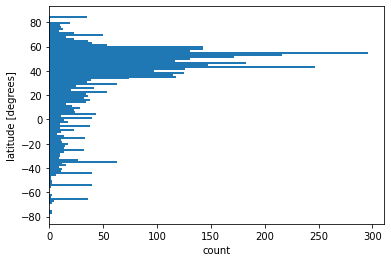

In [8]:
# Using the PSMSL and EU stations gives a skewness towards higher latitudes
# (normalize in results)
fig, ax = plt.subplots()
ax.hist(lat, bins=100, orientation="horizontal")
ax.set_xlabel("count")
ax.set_ylabel("latitude [degrees]")

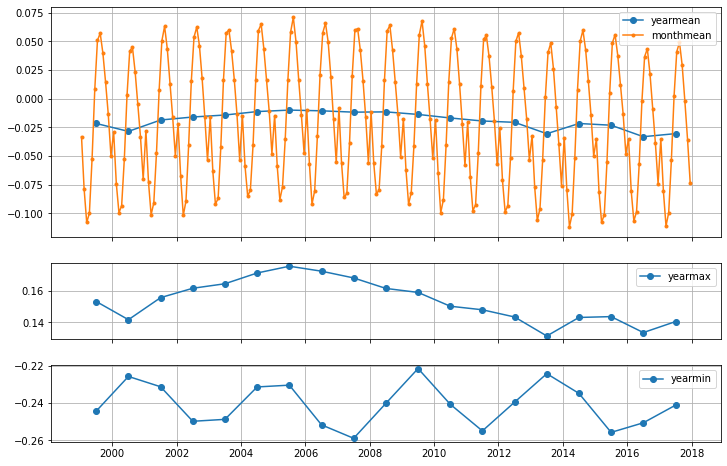

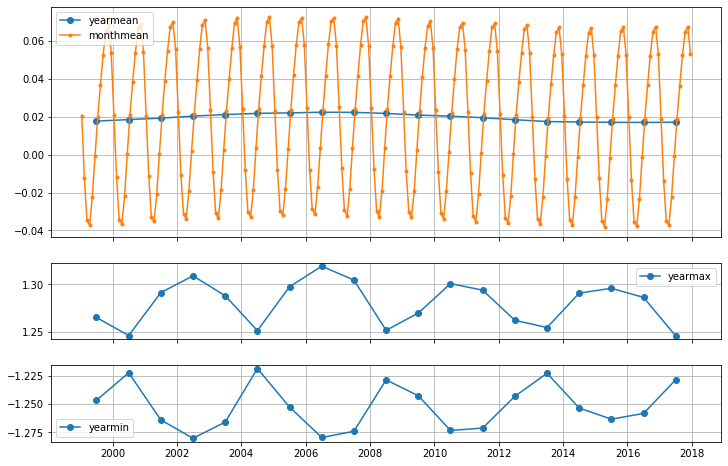

In [9]:
# plot the datasets to check if they are correct.
# there seems to be something wrong for 2014 and 2015 (visible in yearmean and yearmax)
# also december seems off for the monthmeans, this might be because the spinup in december of the previous year is included in the montmean (although this should not be the case)
# yearmin shows a non-nodal pattern
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [3, 1, 1]}, sharex=True
)
wllines = ax1.plot(ds_mean["time"], ds_mean["waterlevel"][:, 0], "o-", label="yearmean")
wllines = ax1.plot(
    ds_monmean["time"], ds_monmean["waterlevel"][:, 0], ".-", label="monthmean"
)
wllines = ax2.plot(ds_max["time"], ds_max["waterlevel"][:, 0], "o-", label="yearmax")
wllines = ax3.plot(ds_min["time"], ds_min["waterlevel"][:, 0], "o-", label="yearmin")
for ax in (ax1, ax2, ax3):
    ax.legend(loc=0)
    ax.grid()
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [3, 1, 1]}, sharex=True
)
wllines = ax1.plot(
    ds_mean["time"], ds_mean["waterlevel"].mean(axis=1), "o-", label="yearmean"
)
wllines = ax1.plot(
    ds_monmean["time"], ds_monmean["waterlevel"].mean(axis=1), ".-", label="monthmean"
)
wllines = ax2.plot(
    ds_max["time"], ds_max["waterlevel"].mean(axis=1), "o-", label="yearmax"
)
wllines = ax3.plot(
    ds_min["time"], ds_min["waterlevel"].mean(axis=1), "o-", label="yearmin"
)
for ax in (ax1, ax2, ax3):
    ax.legend(loc=0)
    ax.grid()

# Mean sea level analysis
We will first analyse mean sea level. For this we will use a simple [harmonic fit](https://www.researchgate.net/profile/Phajm-Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) where we include two linearized components for the nodal tide and a constant sea-level. Using this harmonic fit we estimate the phase, amplitude and mean sea level using an ordinary least squared regression fit. From this fit, we can compute the phase and amplitude per station. 



In [10]:
tidal_components = pd.read_json("tidal-components.json")
tidal_components = tidal_components.set_index("name_cartwright")
epoch_N = datetime.datetime.fromisoformat(tidal_components.loc["$N$"].epoch)
tidal_components

,phase,period,epoch,name_doodson
name_cartwright,,,,
$\tau$,-111.763459,347.809251,1999-12-31 16:17:16.613,$\tau$
$q$,211.737425,13.176396,2000-01-17 01:40:00.354,$s$
$q'$,279.973966,0.985647,2000-10-11 01:13:13.078,$h$
$p$,83.297876,0.111404,2002-01-17 17:06:49.863,$p$
$N$,125.070940,0.052954,2006-06-19 21:20:29.723,$-N'$
$p'$,282.938376,0.000047,18447-02-10 05:08:11.149,$p_1$


In [11]:
def year_fraction(date: datetime.datetime) -> float:
    """convert  a datetime to year fraction

    # considering leap year
    >>> year_fraction(datetime.datetime(2000, 7, 2, 1))
    2000.5
    """
    # timestamp in seconds
    s = date.timestamp()

    year = date.year
    this_year = datetime.datetime(year=year, month=1, day=1)
    next_year = datetime.datetime(year=year + 1, month=1, day=1)

    elapsed = date.timestamp() - this_year.timestamp()
    duration = next_year.timestamp() - this_year.timestamp()
    fraction = elapsed / duration

    return year + fraction


nodal_epoch = year_fraction(
    datetime.datetime.fromisoformat(tidal_components.loc["$N$"].epoch)
)

In [12]:
"""define a simple linear model, with nodal tide and without wind and without sea-level rise"""
X = np.c_[
    np.cos(2 * np.pi * (year - 1970) / 18.613),
    np.sin(2 * np.pi * (year - 1970) / 18.613),
]

# X is of shape n year x 3 parameters
X = sm.add_constant(X)

# Fit through the mean water level of all stations (Y is of shape  n year  x n stations)
Y = ds_mean.waterlevel.values

# define the names
names = ["Constant", "Nodal U", "Nodal V"]

# define the model
model = sm.OLS(Y, X, missing="drop")
# fit the model
fit = model.fit()

Constant = fit.params[0]
A = fit.params[1]
B = fit.params[2]
phase = np.arctan2(B, A)
amplitude = np.sqrt(A ** 2 + B ** 2)
mean = fit.params[0]

In [13]:
"""define a simple linear model, with nodal tide and without wind and without sea-level rise"""
X_nodal_epoch = np.c_[np.sin(2 * np.pi * (year - nodal_epoch) / 18.613)]

# X is of shape n year x 3 parameters
X_nodal_epoch = sm.add_constant(X_nodal_epoch)

# Fit through the mean water level of all stations (Y is of shape  n year  x n stations)
Y = ds_mean.waterlevel.values

# define the names
names_nodal_epoch = ["Constant", "Nodal phase"]

# define the model
model_nodal_epoch = sm.OLS(Y, X_nodal_epoch, missing="drop")
# fit the model
fit_nodal_epoch = model_nodal_epoch.fit()

mean_nodal_epoch = fit.params[0]
amplitude_nodal_epoch = fit.params[1]
amplitude_nodal_epoch

array([ 0.00858625,  0.0095167 ,  0.01172151, ..., -0.00018952,
        0.00727127,  0.00766712])

Text(0, 0.5, 'mean (nodal epoch)')

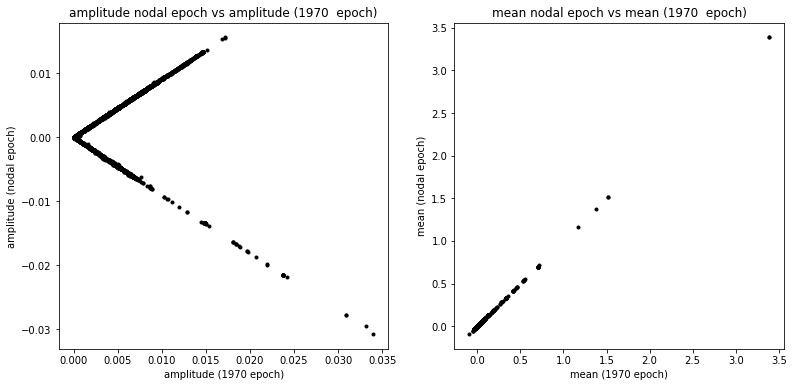

In [14]:
# The amplitude should be independent of the epoch. This should be a straight line
fig, axes = plt.subplots(ncols=2, figsize=(13, 6))

axes[0].plot(amplitude, amplitude_nodal_epoch, "k.")
axes[0].set_title("amplitude nodal epoch vs amplitude (1970  epoch)")
axes[0].set_xlabel("amplitude (1970 epoch)")
axes[0].set_ylabel("amplitude (nodal epoch)")

axes[1].plot(mean, mean_nodal_epoch, "k.")
axes[1].set_title("mean nodal epoch vs mean (1970  epoch)")
axes[1].set_xlabel("mean (1970 epoch)")
axes[1].set_ylabel("mean (nodal epoch)")

In [15]:
# fit the reanalysis nodal cycle through all stations
OLS_wl_yearmean = fit.predict(X)

In [16]:
n_stations = OLS_wl_yearmean.shape[1]


@interact(continuous_update=False)
def make_plot(i=(0, n_stations)):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
    wllines = ax.plot(
        ds_mean["time"], ds_mean["waterlevel"][:, i], "o-", label="yearmean stat0"
    )
    wllines = ax.plot(
        ds_mean["time"], OLS_wl_yearmean[:, i], "o-", label="yearmean OLSpredict stat0"
    )
    ax.legend(loc=0)
    # ax.set_ylim(-0.03, 0.03)
    ax.grid()


make_plot

interactive(children=(IntSlider(value=2102, description='i', max=4204), Output()), _dom_classes=('widget-inter…

<function __main__.make_plot(i=(0, 4204))>

# Check mean sea level
First we check if the mean water level is approximately 0. Possible cause for deviation is that we are using a non-uniform gravity map. 

Then we check if the constant water level is almost equal to the mean water level. If that's the case this histogram should be centered around 0. If this is not the case, we might want to examine a few of the extremes. Other causes for deviations include using a slightly longer time window (we now have exactly one cycle).

(array([1.000e+00, 4.300e+01, 2.872e+03, 1.058e+03, 1.160e+02, 1.800e+01,
        1.900e+01, 9.000e+00, 1.000e+01, 2.000e+00, 5.000e+00, 2.000e+00,
        1.300e+01, 0.000e+00, 8.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        7.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

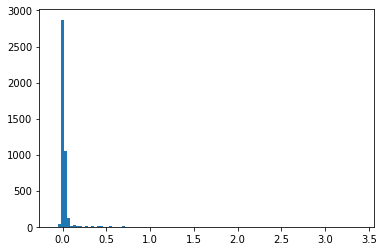

In [17]:
# Check exeptional waterlevels
mean_waterlevel = np.nanmean(ds_mean.waterlevel.values, axis=0)
plt.hist(mean_waterlevel, bins=100)

In [18]:
df_all = pd.DataFrame(
    data=dict(
        lat=lat,
        lon=lon,
        dep=dep,
        mean_waterlevel=mean_waterlevel,
        A=A,
        B=B,
        amplitude=amplitude,
        phase=phase,
        amplitude_nodal_epoch=amplitude_nodal_epoch,
        mean=mean,
    )
)

if "stations_pd" in locals():
    df_all["station_name"] = stations_pd.loc[:, "station_id"]
# df_all = df_all_inclABphs#.drop(['phase','A','B'],axis=1)
df_uniq = df_all.drop_duplicates(["lat", "lon"])

# top 10 highest mean water levels
df_uniq.sort_values("mean_waterlevel", ascending=False).head(n=40)

,lat,lon,dep,mean_waterlevel,A,B,amplitude,phase,amplitude_nodal_epoch,mean,station_name
2823,46.860351,-71.088867,-11.003339,3.387255,-0.007687,0.004082,0.008704,2.653432,-0.007687,3.386131,psmsl-173
603,16.479492,97.602539,-8.821159,1.512246,-0.027750,0.013679,0.030938,2.683609,-0.027750,1.511806,moulmein
3435,61.245114,-149.912109,-7.503355,1.380460,-0.029478,0.015136,0.033137,2.667233,-0.029478,1.379821,psmsl-1067
3032,59.326171,-135.366211,-11.571979,1.163982,-0.030771,0.014448,0.033994,2.702602,-0.030771,1.163315,psmsl-495
3941,36.958007,126.811523,-11.777194,0.715108,-0.021880,0.010204,0.024142,2.705232,-0.021880,0.714693,psmsl-1908
1068,49.445801,0.314941,-5.852910,0.700016,-0.021530,0.010035,0.023753,2.705438,-0.021530,0.699552,IBIS_GL_TS_MO_62449
4157,51.569824,-2.702637,-6.933334,0.556875,-0.017026,0.007838,0.018744,2.710146,-0.017026,0.556599,psmsl-2285
1130,51.511230,-2.717285,-7.182796,0.545699,-0.016723,0.007694,0.018408,2.710365,-0.016723,0.545433,IBIS_IR_TS_MO_Avonmouth
1204,51.496582,-2.731934,-6.431455,0.535976,-0.016432,0.007562,0.018089,2.710285,-0.016432,0.535715,IBIS_IR_TS_MO_Portbury
1326,53.327636,7.243652,-5.334447,0.459714,-0.002387,0.001211,0.002676,2.672188,-0.002387,0.459618,NWS_NO_TS_MO_Emden


Text(0, 0.5, 'N stations')

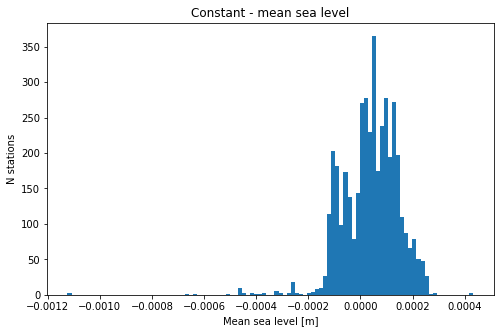

In [19]:
# we don't want the fit of the nodal cycle to result in a different mean, check this.
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(Constant - mean_waterlevel, bins=100)
ax.set_title("Constant - mean sea level")
ax.set_xlabel("Mean sea level [m]")
ax.set_ylabel("N stations")

# Mean sea level map
This map is the mean sea level, taking into account the nodal tide. This map probably correlates to a map of gravity/mass that we used as input. There are a few outliers that have a much higher than average water level.
Also check if the timespan (18 years is causing this). 

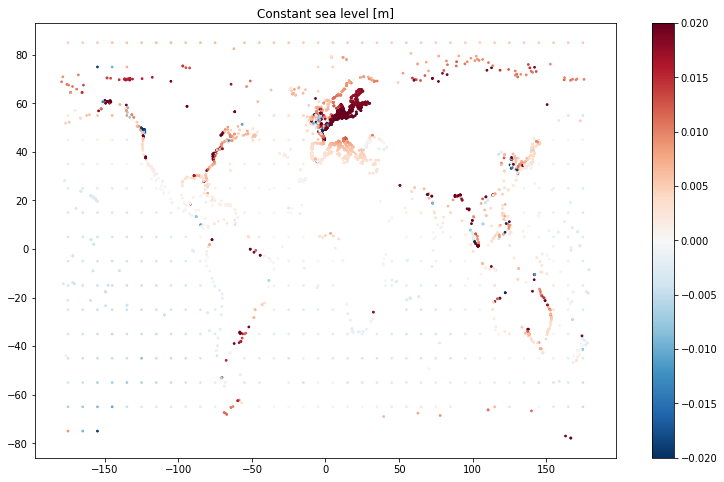

In [20]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Constant sea level [m]")
sc = ax.scatter(
    lon,
    lat,
    c=Constant,
    s=3,
    vmax=0.02,
    vmin=-0.02,
    cmap="RdBu_r",
    label="Mean sea level [m]",
)
plt.colorbar(
    sc,
    ax=ax,
)

# Nodal phase map
This map is the nodal cycle phase. This map probably shows a strong correlation with the [equilibrium](https://www.researchgate.net/profile/Phajm_Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) (figure 4c) tide. Points are scaled with their amplitude so you don't see colors for points without nodal tide, where the phase is random. 

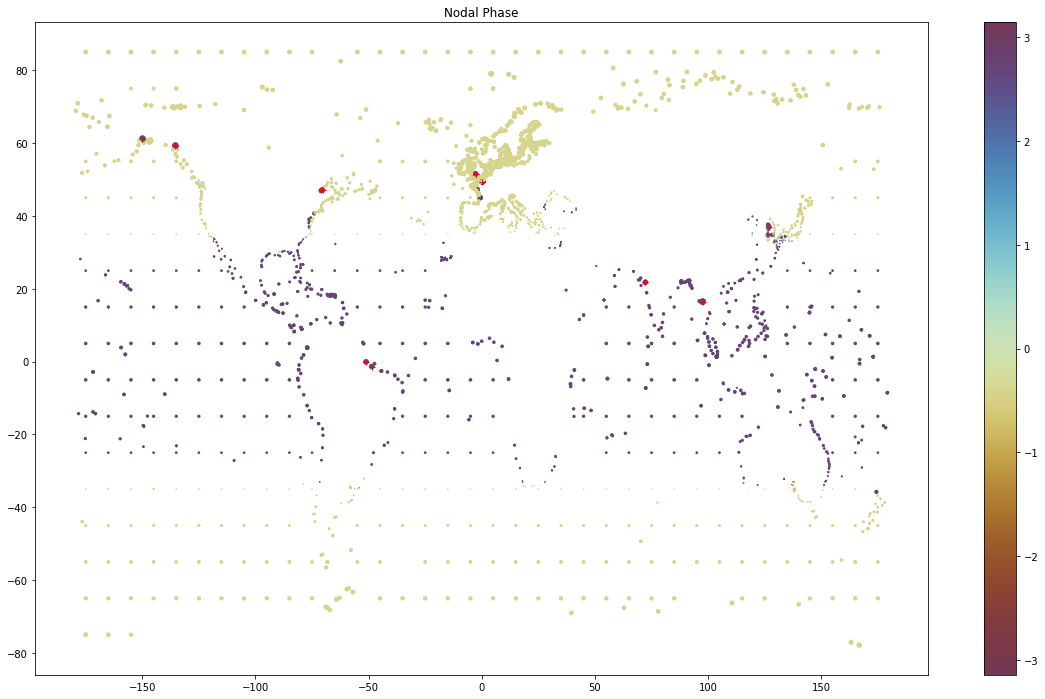

In [21]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_title("Nodal Phase")
sc = ax.scatter(
    lon,
    lat,
    c=phase,
    cmap=cmcrameri.cm.romaO,
    vmin=-np.pi,
    vmax=np.pi,
    s=amplitude * 1000,
)
plt.colorbar(sc, ax=ax)

# show extreme locations that deviate from equilibrium and need to be investigated
top_n = df_uniq.sort_values("amplitude", ascending=False).query("amplitude > 0.018")
ax.plot(top_n["lon"], top_n["lat"], "r+")

# add ldb (useful for zoomed plot)
if 0:
    from dfm_tools.io.polygon import Polygon

    file_pol = data_dir + "/world.ldb"
    pol_data_list, pol_name_list, pol_comment_list = Polygon.fromfile(
        file_pol, pd_output=False
    )
    for iP, pol_data in enumerate(pol_data_list):
        ax.plot(pol_data[:, 0], pol_data[:, 1], "-k", linewidth=0.5)
    ax.set_ylim(-0, 65)
    ax.set_xlim(-80, 140)
    # europe
    ax.set_ylim(44, 53)
    ax.set_xlim(-10, 5)
    # southkorea
    # ax.set_ylim(20,50)
    # ax.set_xlim(100,150)

# western canada (high amp and out of phase): two stations in long and shallow sea arms, not sure why there is a high
# chesepeake bay (out of phase with latitude): due to inlet location
# black sea (out of phase with latitude and Medsea): probably because inlet is closed off
# west of south korea (part of bay is out of phase with latitude): could be due to inlet latitude, but not all points are out of phase. SK coastal points also have high amplitude
# europe (several stations in bays that have high amplitude and are out of phase): shallow stations?

# only high amplitude stations (not checked yet, but validated with timeseries in a different plot): Brazil, west of india, Bangladesh/Myanmar

# Nodal amplitude map
This map is the nodal cycle amplitude. You expect to see higher amplitude at the equator and higher towards the higher latitudes.



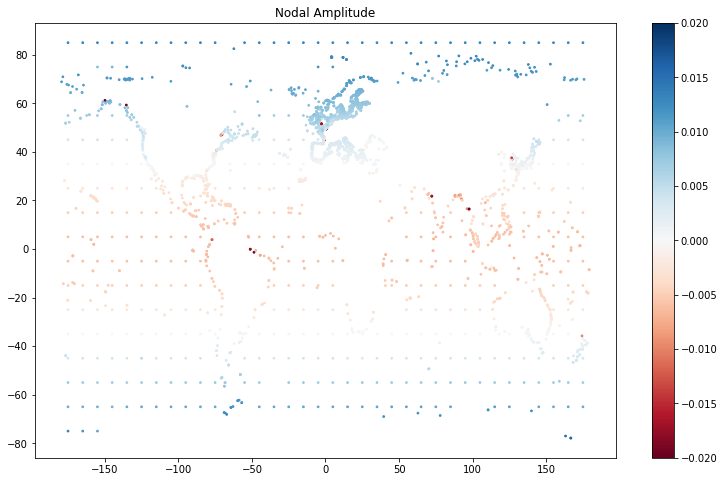

In [22]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Nodal Amplitude")
# im = ax.scatter(lon, lat,  c=amplitude, cmap=cmcrameri.cm.tokyo_r, vmin=0, vmax=0.02, s=3, label='amplitude')
im = ax.scatter(
    lon,
    lat,
    c=amplitude_nodal_epoch,
    cmap="RdBu",
    vmin=-0.02,
    vmax=0.02,
    s=3,
    label="amplitude",
)
plt.colorbar(im, ax=ax)

# Amplitude and phase as a function of latitude
The figures below show the amplitude and phase as a function of latitude. This should be a squared sine function (or something like that) and a dichotomous phase plot, where the equator is in opposite phase.  We see a few points on the east US coast (Chessapeake Bay) that are in the opposite phase from equilibrium. 

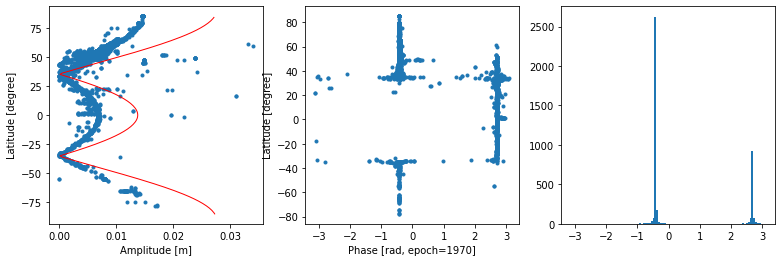

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4))
axes[0].plot(amplitude, lat, ".")
axes[0].set_xlabel("Amplitude [m]")
axes[0].set_ylabel("Latitude [degree]")
axes[1].plot(phase, lat, ".")
axes[1].set_xlabel("Phase [rad, epoch=1970]")
axes[1].set_ylabel("Latitude [degree]")
axes[2].hist(phase, bins=100)


lat_analytic_clean = np.arange(-85, 85, 1)
amp_analytic_clean = (
    np.abs(0.69 * 20 * (3 * np.sin(np.deg2rad(lat_analytic_clean)) ** 2 - 1)) / 1000
)
axes[0].plot(amp_analytic_clean, lat_analytic_clean, "r-", linewidth=1)
amp_analytic = np.abs(0.69 * 20 * (3 * np.sin(np.deg2rad(lat)) ** 2 - 1)) / 1000
df_all["amplitude_analytic"] = amp_analytic

In [24]:
df_uniq_sortamp = df_uniq.sort_values("amplitude", ascending=False).head(n=20)
df_uniq_sortamp

,lat,lon,dep,mean_waterlevel,A,B,amplitude,phase,amplitude_nodal_epoch,mean,station_name
3032,59.326171,-135.366211,-11.571979,1.163982,-0.030771,0.014448,0.033994,2.702602,-0.030771,1.163315,psmsl-495
3435,61.245114,-149.912109,-7.503355,1.380460,-0.029478,0.015136,0.033137,2.667233,-0.029478,1.379821,psmsl-1067
603,16.479492,97.602539,-8.821159,1.512246,-0.027750,0.013679,0.030938,2.683609,-0.027750,1.511806,moulmein
3941,36.958007,126.811523,-11.777194,0.715108,-0.021880,0.010204,0.024142,2.705232,-0.021880,0.714693,psmsl-1908
1068,49.445801,0.314941,-5.852910,0.700016,-0.021530,0.010035,0.023753,2.705438,-0.021530,0.699552,IBIS_GL_TS_MO_62449
3395,47.006835,-70.825195,-10.263537,0.444866,-0.019946,0.009077,0.021914,2.714528,-0.019946,0.444358,psmsl-999
3094,-1.333008,-48.588867,-5.512898,0.294545,-0.019828,0.009275,0.021890,2.704048,-0.019828,0.294123,psmsl-580
3531,47.211913,-70.297852,-6.562790,0.446795,-0.018779,0.008560,0.020638,2.713895,-0.018779,0.446340,psmsl-1223
2972,21.811523,72.290039,-13.223085,0.227833,-0.017930,0.008413,0.019805,2.702878,-0.017930,0.227438,psmsl-420
673,-0.073242,-51.137695,-7.568553,0.280548,-0.017832,0.008298,0.019668,2.706073,-0.017832,0.280182,porto_de_santana


In [25]:
# sort stations on depths, to see if that is an explanation for high nodal amplitudes (however, there are many shallow stations that have a negligible amplitude)
df_uniq_sortdep = df_uniq.sort_values("dep", ascending=False).head(n=20)
# df_uniq_sortdep

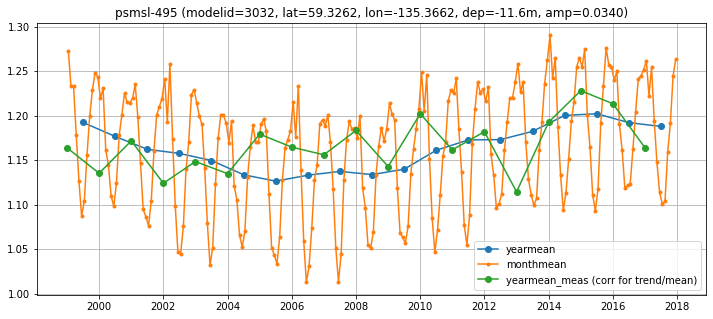

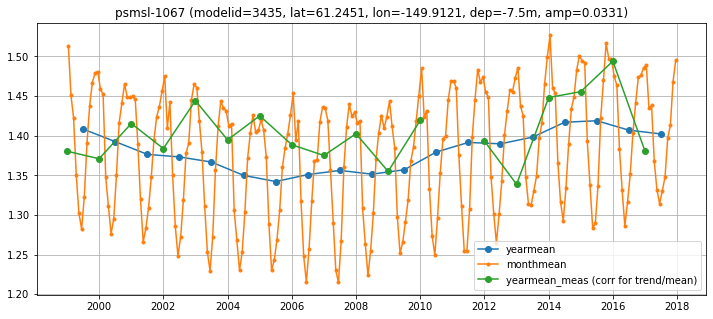

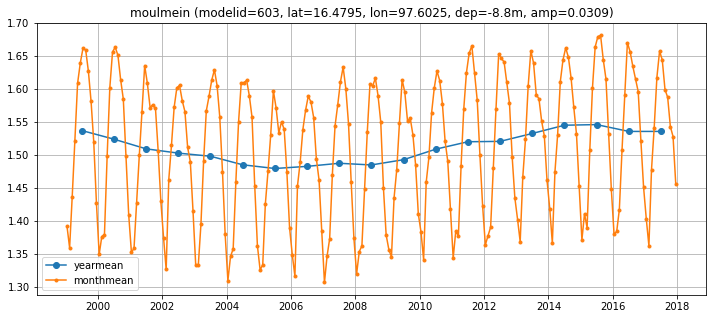

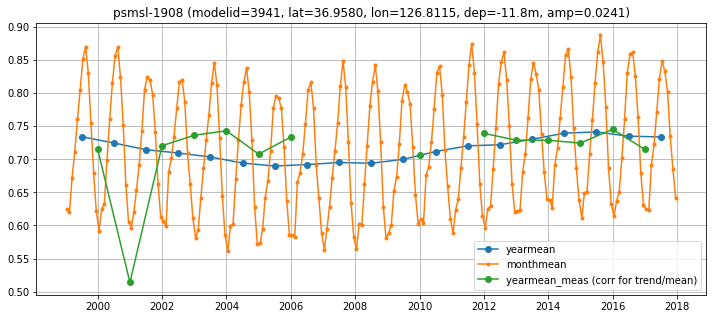

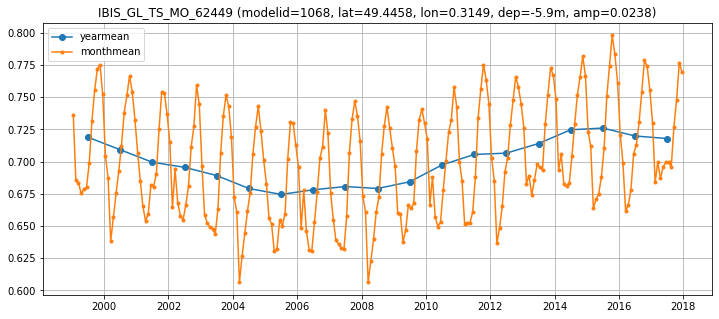

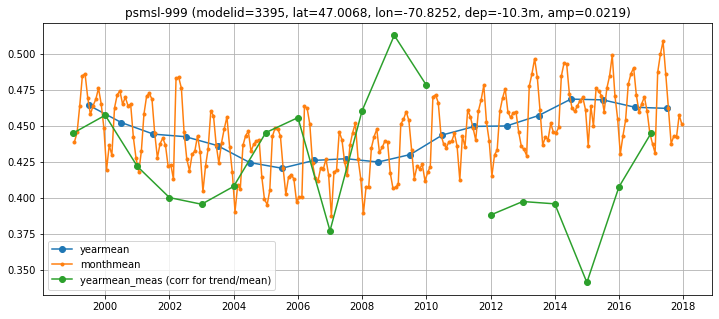

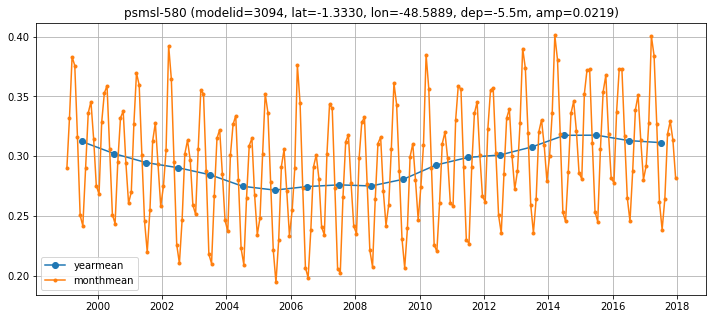

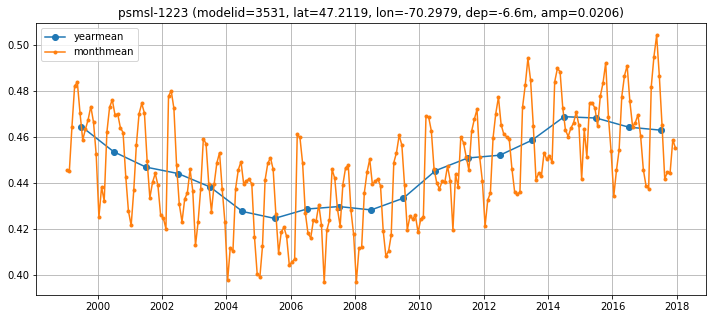

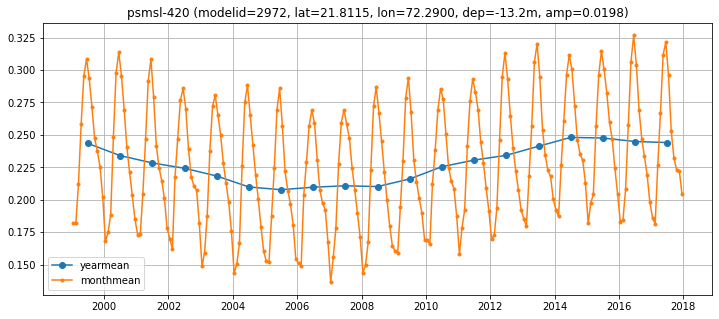

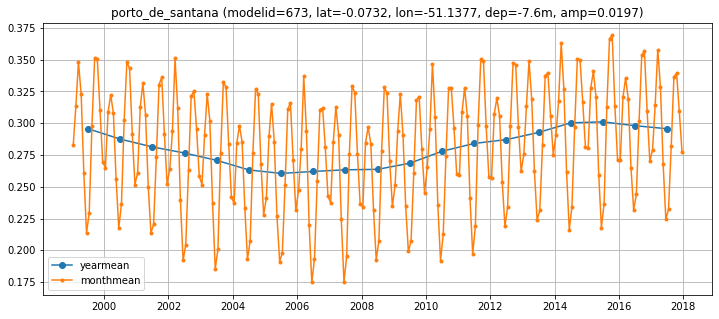

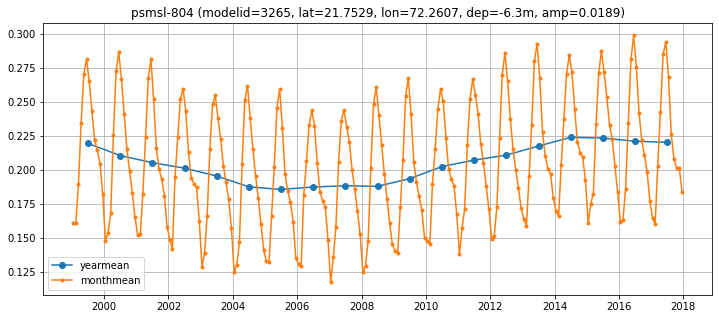

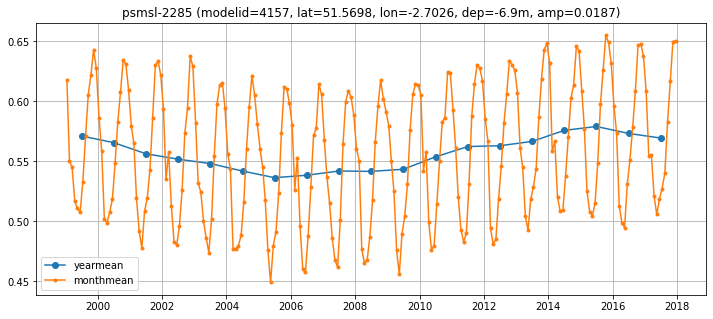

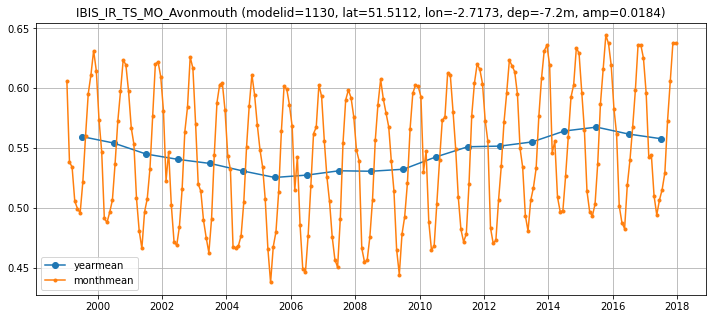

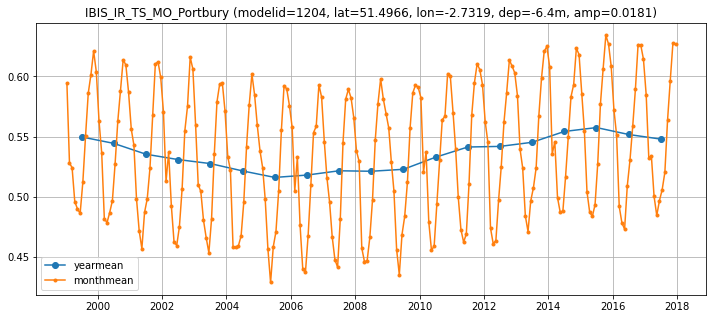

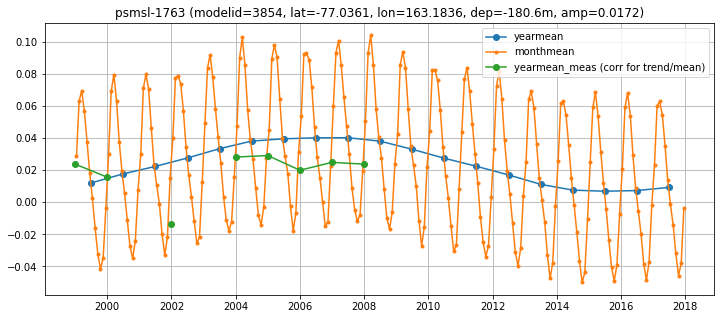

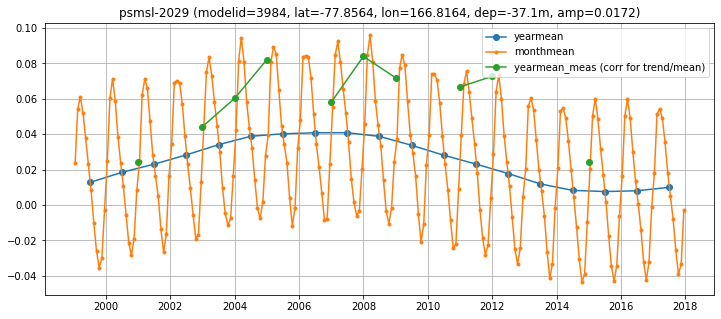

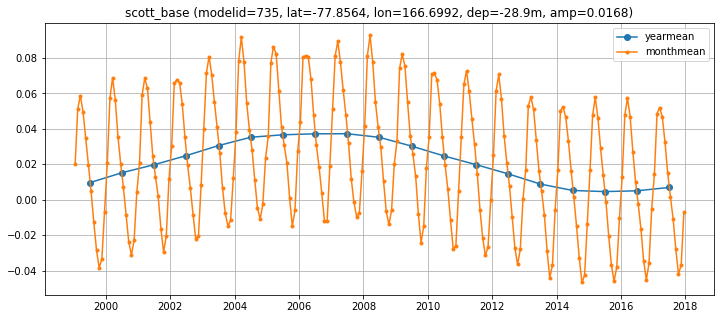

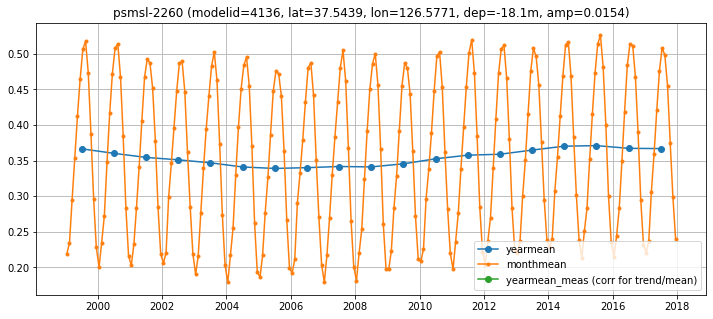

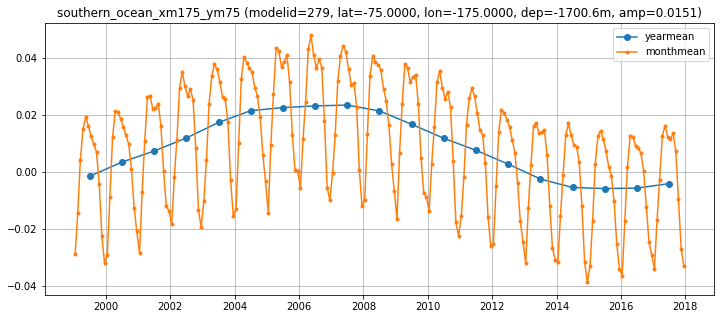

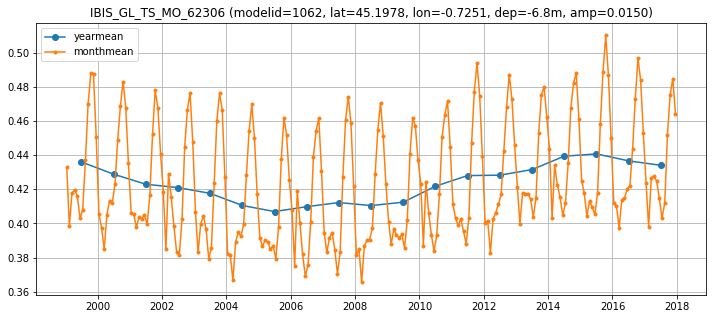

In [26]:
# plot some of the timeseries of outlier stations (higher amplitude than expected).
# First twenty stations indeed show higher amplitude in mean water level
for iR, df_uniq_sortamp_row in df_uniq_sortamp.iloc[:20].iterrows():
    stat_sel = df_uniq_sortamp_row["station_name"]
    stat_modelmean = ds_mean["waterlevel"][:, iR].values.mean()
    fig, (ax1) = plt.subplots(
        1, 1, figsize=(12, 5)
    )  # , gridspec_kw={'height_ratios':[3,1,1]},sharex=True)
    ax1.set_title(
        "%s (modelid=%d, lat=%.4f, lon=%.4f, dep=%.1fm, amp=%.4f)"
        % (stat_sel, iR, lat[iR], lon[iR], dep[iR], df_uniq_sortamp_row["amplitude"])
    )
    wllines = ax1.plot(
        ds_mean["time"], ds_mean["waterlevel"][:, iR], "o-", label="yearmean"
    )
    wllines = ax1.plot(
        ds_monmean["time"], ds_monmean["waterlevel"][:, iR], ".-", label="monthmean"
    )
    if stat_sel.startswith("psmsl"):
        psmsl_id = int(stat_sel.replace("psmsl-", ""))
        meas_stat = measurements[
            (measurements["station"] == psmsl_id)
            & (measurements.index >= datetime.datetime(1999, 1, 1))
            & (measurements.index <= datetime.datetime(2017, 1, 1))
        ]
        nmeas = len(meas_stat["height"])
        # print(nmeas, (~meas_stat['height'].isnull()).sum())
        # print(meas_stat['height'])
        if (~meas_stat["height"].isnull()).sum() > 2:
            meas_stat_trend = np.linspace(
                meas_stat["height"][0], meas_stat["height"][-1], nmeas
            )
            meas_stat_corr = (
                meas_stat.loc[:, "height"] - meas_stat_trend + stat_modelmean
            )
            # print(meas_stat_trend)
            # print(psmsl_id)
            # print(meas_stat)
            ax1.plot(meas_stat_corr, "o-", label="yearmean_meas (corr for trend/mean)")
    ax1.grid()
    ax1.legend()

# Timeseries
Here we visualize all timeseries by computing anomalies per station and sorting them by their latitude. You see the opposite phases around the 40 latitude. 

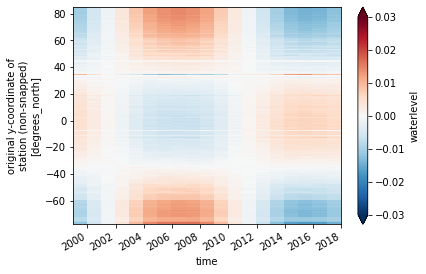

In [27]:
anomaly = ds_mean.waterlevel - ds_mean.waterlevel.mean(axis=0)
idx = np.argsort(ds_mean.station_y_coordinate.values)
anomaly[:, idx].plot(
    y="station_y_coordinate", x="time", vmin=-0.03, vmax=0.03, cmap="RdBu_r"
)
# ds_mean.time[7]

# Nodal Maximum water  level
The nodal tidal maximum follows a different cycle. The amplitudes do not follow equilibrium tide.

In [28]:
year_max = np.array(
    [x.year for x in ds_max.waterlevel.time.values.astype("M8[ms]").astype("O")],
    dtype="double",
)
year_min = np.array(
    [x.year for x in ds_min.waterlevel.time.values.astype("M8[ms]").astype("O")],
    dtype="double",
)

assert np.allclose(year_max, year_min)
year = year_min

In [29]:
X = np.c_[
    np.cos(2 * np.pi * (year - 1970) / 18.613),
    np.sin(2 * np.pi * (year - 1970) / 18.613),
]


Y = ds_max.waterlevel.values
names = ["Constant", "Nodal U", "Nodal V"]
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing="drop")
fit = model.fit()
A = fit.params[1]
B = fit.params[2]
phase_max = np.arctan2(B, A)
amplitude_max = np.sqrt(A ** 2 + B ** 2)

(-10.0, 10.0)

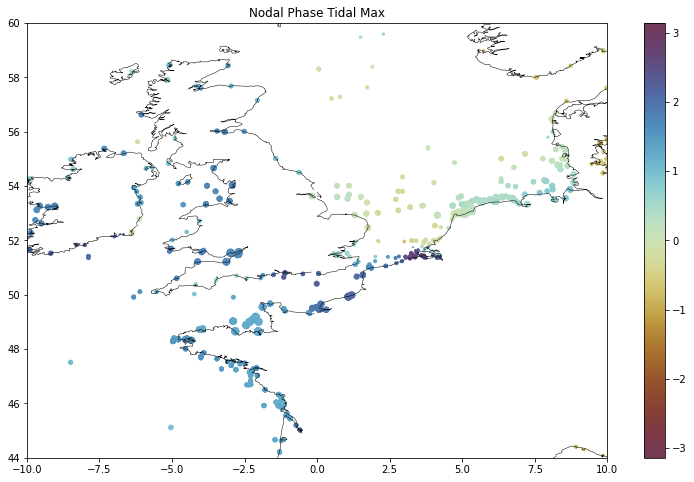

In [30]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Nodal Phase Tidal Max")
sc = ax.scatter(
    lon,
    lat,
    c=phase_max,
    cmap=cmcrameri.cm.romaO,
    vmin=-np.pi,
    vmax=np.pi,
    s=amplitude_max * 1000,
)
plt.colorbar(sc, ax=ax)

from dfm_tools.io.polygon import Polygon

file_pol = data_dir / "world.ldb"
pol_data_list, pol_name_list, pol_comment_list = Polygon.fromfile(
    file_pol, pd_output=False
)
for iP, pol_data in enumerate(pol_data_list):
    ax.plot(pol_data[:, 0], pol_data[:, 1], "-k", linewidth=0.5)
# europe
ax.set_ylim(44, 60)
ax.set_xlim(-10, 10)

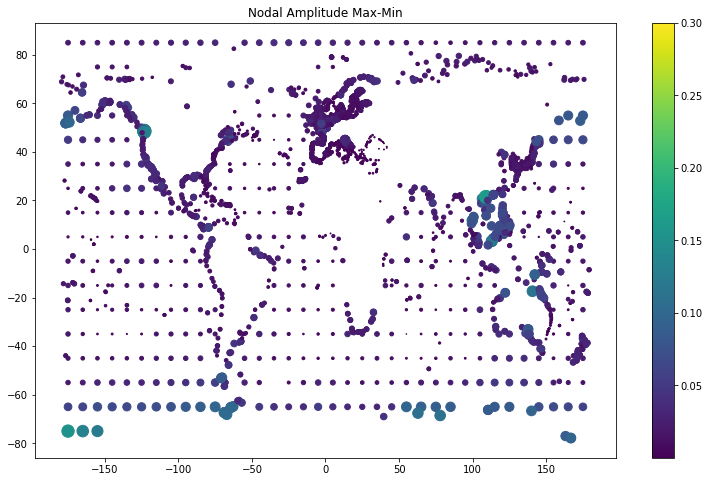

In [31]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Nodal Amplitude Max-Min")
im = ax.scatter(
    lon,
    lat,
    c=amplitude_max,
    cmap="viridis",
    vmax=0.3,
    s=amplitude_max * 1000,
    label="amplitude_max",
)
plt.colorbar(im, ax=ax)

(array([  6.,   7.,   7.,   8.,   0.,   4.,   5.,   2.,   5.,   4.,   3.,
          4.,   1.,   8.,   5.,   3.,   4.,   9.,   5.,   3.,   5.,   3.,
         10.,  11.,   0.,  12.,   9.,  14.,  12.,  10.,  14.,  25.,  16.,
         55.,  74.,  90.,  76.,  96., 122., 256., 221., 232., 175., 132.,
         94.,  93.,  97., 117.,  62.,  41.,  50.,  56.,  67.,  52.,  47.,
         39.,  45.,  47.,  21.,  42.,  42.,  43.,  29.,  23.,  37.,  46.,
         54.,  36.,  46.,  75., 110., 107.,  54.,  73.,  38.,  61.,  52.,
         63.,  34.,  23.,  37.,  26.,  27.,  29.,  28.,  17.,  32.,  15.,
         19.,  22.,  28.,  36.,  20.,  20.,  19.,   8.,  14.,   7.,  12.,
          9.]),
 array([-3.12766333, -3.06501886, -3.00237438, -2.93972991, -2.87708543,
        -2.81444095, -2.75179648, -2.689152  , -2.62650753, -2.56386305,
        -2.50121858, -2.4385741 , -2.37592963, -2.31328515, -2.25064068,
        -2.1879962 , -2.12535173, -2.06270725, -2.00006278, -1.9374183 ,
        -1.87477383, -1.81

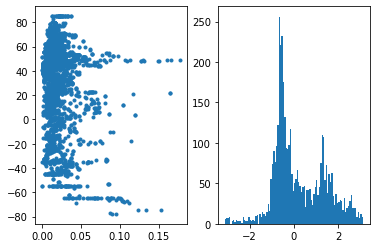

In [32]:
fig, axes = plt.subplots(ncols=2)
axes[0].plot(amplitude_max, lat, ".")
axes[1].hist(phase_max, bins=100)

##  Black Sea filter
The Black Sea is not properly connected in the GTSM 4.0  schematisation. Filter  these stations  out of the list.
We only export stations that can be linked to a PSMSL station.

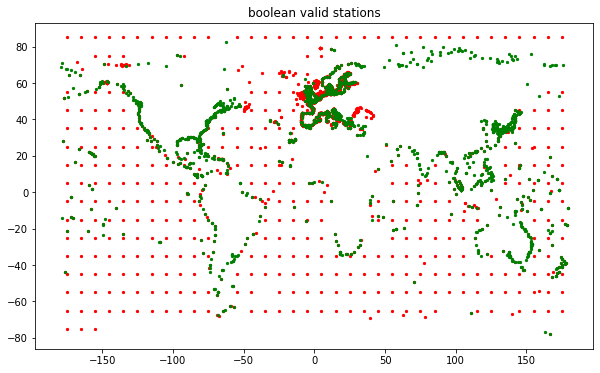

In [33]:
# Define a square where  the black sea is
# We refer to this as the black sea boolean filter
# Check with future schematisations if the channel to the
# Black Sea is properly connected
df_areaBS_bool = (
    (df_all["lon"] > 27)
    & (df_all["lon"] < 44)
    & (df_all["lat"] > 40)
    & (df_all["lat"] < 48)
)

#  lookup stations that are in the psmsl list
bool_psmsl = df_all["station_name"].str.contains("psmsl")

#  combine with the black sea filter
df_validstats_bool = ~df_areaBS_bool & bool_psmsl
df_validstats_idx = np.where(df_validstats_bool)[0]

# show the stations (green, psms + not in black sea) that we are exporting
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("boolean valid stations")
sc = ax.scatter(lon[~df_validstats_bool], lat[~df_validstats_bool], c="r", s=5)
sc = ax.scatter(lon[df_validstats_bool], lat[df_validstats_bool], c="g", s=5)

In [34]:
column_names = {
    "lon": "longitude [degrees east]",
    "lat": "latitude [degrees north]",
    "station_name": "station_name",
    "A": "nodal tide U [m]",
    "B": "nodal tide V [m]",
    "amplitude": "nodal amplitude [m]",
    "phase": "nodal phase [radians since 1970-01-01]",
    "mean": "mean sea surface height of nodal fit [m]",
    "amplitude_nodal_epoch": "nodal amplitude fitted with nodal epoch [m]",
    "amplitude_analytic": "nodal amplitude of equilibrium tide [m]",
}

In [35]:
# data export
dir_out = os.path.join(data_dir, "output_csv")
if not os.path.exists(dir_out):
    os.mkdir(dir_out)

# write OLS yearmean parameters and analytic amplitude
list_columns = [
    "lon",
    "lat",
    "station_name",
    "A",
    "B",
    "amplitude",
    "phase",
    "mean",
    "amplitude_nodal_epoch",
    "amplitude_analytic",
]
df_OLSmodelstats = df_all.loc[df_validstats_bool, list_columns]
df_OLSmodelstats = df_OLSmodelstats.rename(columns=column_names)
df_OLSmodelstats.to_csv(os.path.join(dir_out, "df_OLSmodelstats_year.csv"), index=False)

# write yearly/monthly values per station
dates_yearmean = ds_mean.waterlevel.time.values.astype("M8[ms]").astype("O")
datestr_yearmean = ["%d" % (x.year) for x in dates_yearmean]
# Monthly means
dates_monmean = ds_monmean.waterlevel.time.values.astype("M8[ms]").astype("O")
datestr_monmean = ["%d-%02d" % (x.year, x.month) for x in dates_monmean]

# number of stations
nstats = 0
psmsl_stats_discarded = []
for iS, pd_row in stations_pd.iterrows():
    # print(iS, pd_row)
    stat_name = pd_row["station_name"]
    if iS in df_validstats_idx:
        nstats += 1
        stat_tsyear = pd.DataFrame(
            data={
                "time [year]": datestr_yearmean,
                "sea_surface_height_due_to_tide [m]": ds_mean["waterlevel"][:, iS],
            }
        )
        stat_tsyear.to_csv(
            os.path.join(dir_out, "yearlymean_gtsm_%s.csv" % (stat_name)), index=False
        )

        stat_tsyearOLS = pd.DataFrame(
            data={
                "time [year]": datestr_yearmean,
                "sea_surface_height_due_to_tide_fitted [m]": OLS_wl_yearmean[:, iS],
            }
        )
        stat_tsyearOLS.to_csv(
            os.path.join(dir_out, "yearlymeanOLS_gtsm_%s.csv" % (stat_name)),
            index=False,
        )

        stat_tsmonth = pd.DataFrame(
            data={
                "time [year-month]": datestr_monmean,
                "sea_surface_height_due_to_tide [m]": ds_monmean["waterlevel"][:, iS],
            }
        )
        stat_tsmonth.to_csv(
            os.path.join(dir_out, "monthlymean_gtsm_%s.csv" % (stat_name)), index=False
        )
    # keep track of discarded psmsl stations
    elif "psmsl" in stat_name:
        psmsl_stats_discarded.append(stat_name)
# stations in black sea:
# 41, 51, 215, 317, 318, 379, 1926, 1927
print("discarded PSMSL stations (in Black Sea):\n%s" % (psmsl_stats_discarded))

discarded PSMSL stations (in Black Sea):
['psmsl-41', 'psmsl-51', 'psmsl-215', 'psmsl-317', 'psmsl-318', 'psmsl-379', 'psmsl-1926', 'psmsl-1927']


In [36]:
!open {data_dir}